# Importing RNA Protein Dataset

In [1]:
import pandas as pd 
import numpy as np
import pickle


protein_1460 = pickle.load(open(r'C:\Research\MultiModal_Biological_LLM\Datasets\Protein_RNA\Processed_Files\1807\protein_embeddings_1807.pkl', 'rb'))
rna_1460 = pickle.load(open(r'C:\Research\MultiModal_Biological_LLM\Datasets\Protein_RNA\Processed_Files\1807\rna_embeddings_1807.pkl', 'rb'))
lebels = pickle.load(open(r'C:\Research\MultiModal_Biological_LLM\Datasets\Protein_RNA\Processed_Files\1807\labels_1807.pkl', 'rb'))



In [2]:
rna_1460[0].shape

torch.Size([1, 768])

# Creating the dataloader

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class InteractionDataset(Dataset):
    def __init__(self, interaction_data, interaction_labels):
        """
        Args:
            interaction_data (list): A list where each item is another list containing
                                     the protein embeddings as the first element and
                                     the RNA embeddings as the second element.
            interaction_labels (list): A list of labels (0 or 1).
        """
        self.interaction_data = interaction_data
        self.interaction_labels = interaction_labels

    def __len__(self):
        return len(self.interaction_labels)

    def __getitem__(self, idx):
        protein_emb, rna_emb = self.interaction_data[idx]
        label = self.interaction_labels[idx]
        label = torch.tensor(int(label))    
        return (protein_emb.squeeze(0), rna_emb[0]), label

interaction_dataset = InteractionDataset(list(zip(protein_1460, rna_1460)), lebels)
# interaction_dataloader = DataLoader(interaction_dataset, batch_size=32, shuffle=True)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming the InteractionDataset and InteractionModel have been defined as previous sections

# Split the dataset into training and validation
dataset_size = len(interaction_dataset)
train_size = int(dataset_size * 1)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(interaction_dataset, [train_size, val_size])

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
for data, label in train_dataloader:
    print(data[0].shape)
    print(data[1].shape)
    print(label)
    break

torch.Size([32, 1024])
torch.Size([32, 768])
tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0])


In [22]:
protein_emb_size = 1024
rna_emb_size = 768

In [23]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CrossAttentionModule(nn.Module):
#     def __init__(self, query_dim, key_value_dim, num_heads):
#         super().__init__()
#         self.attention = nn.MultiheadAttention(embed_dim=key_value_dim, num_heads=num_heads)

#     def forward(self, query_emb, key_value_emb):
#         # Multi-head attention expects input of shape (L, N, E) - (sequence length, batch size, embedding dimension)
#         # Here we treat each embedding as a sequence of length 1.
#         query_emb = query_emb.unsqueeze(0)  # Shape: (1, batch_size, query_dim)
#         key_value_emb = key_value_emb.unsqueeze(0)  # Shape: (1, batch_size, key_value_dim)
        
#         # Apply attention
#         attended_values, _ = self.attention(query_emb, key_value_emb, key_value_emb)
#         return attended_values.squeeze(0)  # Remove sequence length dimension

# class InteractionModel(nn.Module):
#     def __init__(self, protein_dim, rna_dim, reduced_dim, num_heads):
#         super().__init__()
#         self.protein_to_reduced = nn.Sequential(
#             nn.Linear(protein_dim, reduced_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
        
#         self.cross_attention = CrossAttentionModule(rna_dim, reduced_dim, num_heads)
#         self.layer_norm = nn.LayerNorm(reduced_dim)
        
#         self.classifier = nn.Sequential(
#             nn.Linear(reduced_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 1)
#         )

#     def forward(self, protein_emb, rna_emb):
#         reduced_protein_emb = self.protein_to_reduced(protein_emb)
#         cross_attended = self.cross_attention(rna_emb, reduced_protein_emb)
#         normalized = self.layer_norm(cross_attended)
#         logits = self.classifier(normalized)
#         return torch.sigmoid(logits)
    

# model = InteractionModel(protein_dim=1024, rna_dim=768, reduced_dim=768, num_heads=8)
# # count the number of trainable parameters in the model
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

In [24]:
import torch
import torch.nn as nn

class GatedFeatureFusion(nn.Module):
    """Gates to control the contribution of each path"""
    def __init__(self, input_dim):
        super().__init__()
        self.gate = nn.Parameter(torch.rand(input_dim))

    def forward(self, x1, x2):
        # print(x1.shape, x2.shape)
        gate_values = torch.sigmoid(self.gate)
        return x1 * gate_values + x2 * (1 - gate_values), gate_values

class DualPathNetwork(nn.Module):
    def __init__(self, protein_dim, rna_dim, hidden_dim):
        super().__init__()
        self.protein_path = nn.Sequential(
            nn.Linear(protein_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.rna_path = nn.Sequential(
            nn.Linear(rna_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.fusion = GatedFeatureFusion(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, protein_emb, rna_emb):
        protein_features = self.protein_path(protein_emb)
        rna_features = self.rna_path(rna_emb)
        combined_features, gate_values = self.fusion(protein_features, rna_features)
        logits = self.classifier(combined_features)
        return torch.sigmoid(logits), gate_values

# Example instantiation
model_dual_path = DualPathNetwork(protein_dim=1024, rna_dim=768, hidden_dim=512)


In [25]:
# class ProteinRNAClassifier(nn.Module):
#     def __init__(self, protein_dim, rna_dim):
#         super().__init__()
#         # Separate fully connected layers for protein and RNA features
#         self.protein_fc = nn.Linear(protein_dim, 512)  # Process protein features
#         self.rna_fc = nn.Linear(rna_dim, 512)          # Process RNA features
        
#         # Combined fully connected layers for the concatenated features
#         self.combined_fc1 = nn.Linear(512 * 2, 512)
#         self.combined_fc2 = nn.Linear(512, 64)
#         self.combined_fc3 = nn.Linear(64, 1)  # Output layer for binary classification

#     def forward(self, protein, rna):
#         # Process protein and RNA features through their respective fully connected layers
#         protein = F.relu(self.protein_fc(protein))
#         rna = F.relu(self.rna_fc(rna))
        
#         # Concatenate the processed features
#         combined = torch.cat((protein, rna), dim=1)
        
#         # Fully connected layers with ReLU activations for the combined features
#         x = F.relu(self.combined_fc1(combined))
#         x = F.relu(self.combined_fc2(x))
#         x = torch.sigmoid(self.combined_fc3(x)).squeeze(1)  # Use sigmoid for binary classification
        
#         return x

# protein_dim = 1024
# rna_dim = 768
# # Initialize the model
# model = ProteinRNAClassifier(protein_dim, rna_dim)

# # count the number of trainable parameters in the model
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

In [29]:


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  

set_seed(42)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from sklearn.model_selection import KFold

# Assuming the InteractionDataset and InteractionModel have been defined as previous sections

# DataLoader
batch_size = 32

# Initialize the model


# Function to calculate MCC
def calculate_mcc(y_true, y_pred):
    y_pred = np.round(y_pred)
    return matthews_corrcoef(y_true, y_pred)

# Function to calculate additional metrics
def calculate_metrics(y_true, y_pred):
    y_pred = np.round(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    return acc, f1, precision, recall, specificity

# Training and validation function
def train_model(train_loader, val_loader, epochs):
    best_metrics = {
        'mcc': 0,
        'acc': 0,
        'f1': 0,
        'precision': 0,
        'recall': 0,
        'specificity': 0
    }
    model = DualPathNetwork(1024, 768, hidden_dim=512)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_labels = []
        train_preds = []
        for embeddings, labels in train_loader:
            protein_emb, rna_emb = embeddings
            protein_emb, rna_emb, labels = protein_emb.to(device), rna_emb.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(protein_emb, rna_emb)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            train_labels.extend(labels.tolist())
            train_preds.extend(outputs.detach().cpu().numpy())

        train_mcc = calculate_mcc(train_labels, train_preds)
        
        # Validation loop
        model.eval()
        with torch.no_grad():
            val_labels = []
            val_preds = []
            for embeddings, labels in val_loader:
                protein_emb, rna_emb = embeddings
                protein_emb, rna_emb, labels = protein_emb.to(device), rna_emb.to(device), labels.to(device)
                outputs, _ = model(protein_emb, rna_emb)
                outputs = outputs.squeeze()
                val_labels.extend(labels.tolist())
                val_preds.extend(outputs.cpu().numpy())
        
        val_mcc = calculate_mcc(val_labels, val_preds)
        if val_mcc > best_metrics['mcc']:
            best_metrics['mcc'] = val_mcc
            best_metrics['acc'], best_metrics['f1'], best_metrics['precision'], best_metrics['recall'], best_metrics['specificity'] = calculate_metrics(val_labels, val_preds)
            print(f'Epoch {epoch+1}: Train MCC: {train_mcc:.4f}, Val MCC: {val_mcc:.4f}')

       
    
    return best_metrics

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)
cv_results = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(interaction_dataset)):
    train_subset = Subset(interaction_dataset, train_idx)
    val_subset = Subset(interaction_dataset, val_idx)
    
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    print(f'Fold {fold+1}')
    best_metrics = train_model(train_dataloader, val_dataloader, epochs=100)
    cv_results[fold + 1] = best_metrics

print(cv_results)


Fold 1
Epoch 1: Train MCC: 0.5299, Val MCC: 0.8987
Epoch 2: Train MCC: 0.9075, Val MCC: 0.9744
Epoch 3: Train MCC: 0.9447, Val MCC: 0.9829
Epoch 5: Train MCC: 0.9628, Val MCC: 0.9830
Epoch 6: Train MCC: 0.9590, Val MCC: 0.9915
Fold 2
Epoch 1: Train MCC: 0.4601, Val MCC: 0.8547
Epoch 2: Train MCC: 0.9113, Val MCC: 0.9145
Epoch 3: Train MCC: 0.9456, Val MCC: 0.9317
Epoch 6: Train MCC: 0.9695, Val MCC: 0.9573
Epoch 10: Train MCC: 0.9743, Val MCC: 0.9660
Fold 3
Epoch 1: Train MCC: 0.5260, Val MCC: 0.8417
Epoch 2: Train MCC: 0.9237, Val MCC: 0.9233
Epoch 3: Train MCC: 0.9494, Val MCC: 0.9410
Epoch 7: Train MCC: 0.9752, Val MCC: 0.9492
Fold 4
Epoch 1: Train MCC: 0.4577, Val MCC: 0.8549
Epoch 2: Train MCC: 0.8961, Val MCC: 0.9570
Epoch 3: Train MCC: 0.9352, Val MCC: 0.9656
Epoch 5: Train MCC: 0.9638, Val MCC: 0.9828
Epoch 18: Train MCC: 0.9733, Val MCC: 0.9914
Fold 5
Epoch 1: Train MCC: 0.5096, Val MCC: 0.8643
Epoch 2: Train MCC: 0.9171, Val MCC: 0.9221
Epoch 3: Train MCC: 0.9543, Val MCC: 0.

In [32]:
# iterate the dictionary and calculate the average metrics
metrics = ['mcc', 'acc', 'f1', 'precision', 'recall', 'specificity']
avg_metrics = {metric: 0 for metric in metrics}
for fold, results in cv_results.items():
    for metric in metrics:
        avg_metrics[metric] += results[metric]

num_folds = len(cv_results)
for metric in metrics:
    avg_metrics[metric] /= num_folds
    

(avg_metrics)

{'mcc': 0.9777396918395473,
 'acc': 0.9888613770588022,
 'f1': 0.9887834116886702,
 'precision': 0.9864111164147156,
 'recall': 0.9912854424780846,
 'specificity': 0.9862036763959052}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9448\2355974760.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df, palette=palette)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9448\2355974760.py:17: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x='Metric', y='Value', data=df, palette=palette)
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and 

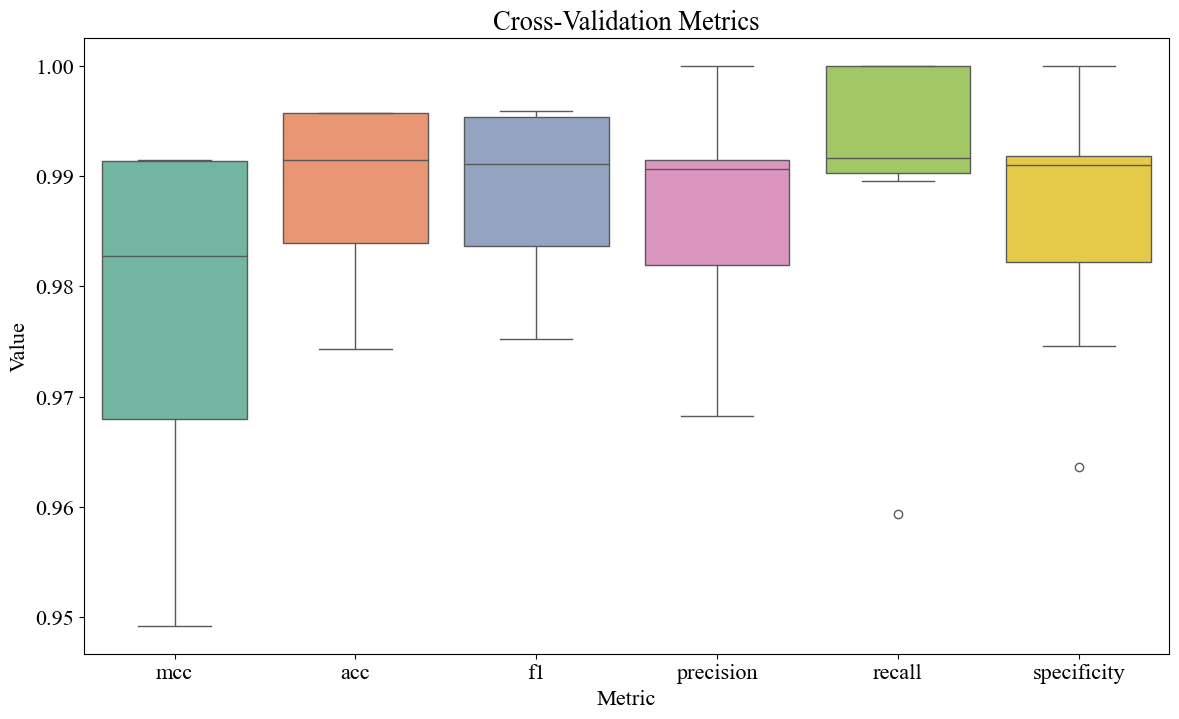

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Convert the results dictionary into a DataFrame
data = []
for fold, metrics in cv_results.items():
    for metric, value in metrics.items():
        data.append([fold, metric, value])

df = pd.DataFrame(data, columns=['Fold', 'Metric', 'Value'])

# Set the color palette
palette = sns.color_palette("Set2")

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Metric', y='Value', data=df, palette=palette)

# Add a title and labels
plt.title('Cross-Validation Metrics')
plt.ylabel('Value')
plt.xlabel('Metric')

# Show the plot
plt.show()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define methods and their approximate means and standard deviations
methods = {
    'RPISeq-RF': {
        'MCC': (0.57, 0.05),
        'ACC': (0.78, 0.05),
        'F1': (0.78, 0.05),
        'Precision': (0.79, 0.05),
        'Recall': (0.78, 0.05),
        'Specificity': (0.79, 0.05)
    },

    'IMPIner': {
        'MCC': (0.52, 0.05),
        'ACC': (0.76, 0.05),
        'F1': (0.77, 0.05),
        'Precision': (0.72, 0.05),
        'Recall': (0.83, 0.05),
        'Specificity': (0.67, 0.05)
    },

    'CFRP': {
        'MCC': (0.63, 0.05),
        'ACC': (0.81, 0.05),
        'F1': (0.82, 0.05),
        'Precision': (0.83, 0.05),
        'Recall': (0.78, 0.05),
        'Specificity': (0.80, 0.05)
    },

    'RPITER': {
        'MCC': (0.412, 0.05),
        'ACC': (0.69, 0.05),
        'F1': (0.51, 0.05),
        'Precision': (0.61, 0.05),
        'Recall': (0.48, 0.05),
        'Specificity': (0.90, 0.05)
    },

    'LPI-CSFFR': {
        'MCC': (0.6, 0.05),
        'ACC': (0.83, 0.05),
        'F1': (0.84, 0.05),
        'Precision': (0.78, 0.05),
        'Recall': (0.91, 0.05),
        'Specificity': (0.75, 0.05)
    },

    'RNAincoder': {
        'MCC': (0.76, 0.02),
        'ACC': (0.88, 0.02),
        'F1': (0.84, 0.02),
        'Precision': (0.81, 0.02),
        'Recall': (0.94, 0.02),
        'Specificity': (0.87, 0.02)
    }

}


biollmnet = {{'MCC': 0.84831, 'ACC': 0.9225899999999999, 'F1': 0.9254499999999999, 'Precision': 0.8883400000000001, 'Recall': 0.9663400000000001, 'Specificity': 0.8789}}

# BioLLMNet results
biollmnet_results = {
    1: {'MCC': 0.8322, 'ACC': 0.9144, 'F1': 0.9117, 'Precision': 0.8716, 'Recall': 0.9556, 'Specificity': 0.8790},
    2: {'MCC': 0.8071, 'ACC': 0.9007, 'F1': 0.9129, 'Precision': 0.8588, 'Recall': 0.9744, 'Specificity': 0.8162},
    3: {'MCC': 0.8686, 'ACC': 0.9349, 'F1': 0.9436, 'Precision': 0.9191, 'Recall': 0.9695, 'Specificity': 0.8906},
    4: {'MCC': 0.8842, 'ACC': 0.9418, 'F1': 0.9453, 'Precision': 0.9245, 'Recall': 0.9671, 'Specificity': 0.9143},
    5: {'MCC': 0.8736, 'ACC': 0.9349, 'F1': 0.9352, 'Precision': 0.8954, 'Recall': 0.9786, 'Specificity': 0.8947},
    6: {'MCC': 0.8167, 'ACC': 0.9041, 'F1': 0.9034, 'Precision': 0.8452, 'Recall': 0.9704, 'Specificity': 0.8471},
    7: {'MCC': 0.8642, 'ACC': 0.9315, 'F1': 0.9342, 'Precision': 0.9103, 'Recall': 0.9595, 'Specificity': 0.9028},
    8: {'MCC': 0.8208, 'ACC': 0.9075, 'F1': 0.9121, 'Precision': 0.8642, 'Recall': 0.9655, 'Specificity': 0.8503},
    9: {'MCC': 0.8701, 'ACC': 0.9349, 'F1': 0.9397, 'Precision': 0.9193, 'Recall': 0.9610, 'Specificity': 0.9058},
    10: {'MCC': 0.8456, 'ACC': 0.9212, 'F1': 0.9164, 'Precision': 0.8750, 'Recall': 0.9618, 'Specificity': 0.8882}
}


biollmnet_avg = {
    'MCC': 0,
    'ACC': 0,
    'F1': 0,
    'Precision': 0,
    'Recall': 0,
    'Specificity': 0
}

for fold, results in biollmnet_results.items():
    for metric, value in results.items():
        biollmnet_avg[metric] += value

num_folds = len(biollmnet_results)
for metric in biollmnet_avg:
    biollmnet_avg[metric] /= num_folds

print(biollmnet_avg)    


{'MCC': 0.84831, 'ACC': 0.9225899999999999, 'F1': 0.9254499999999999, 'Precision': 0.8883400000000001, 'Recall': 0.9663400000000001, 'Specificity': 0.8789}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9448\3128778337.py:28: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.boxplot(x='Metric', y='Value', hue='Method', data=df, palette=palette)
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in

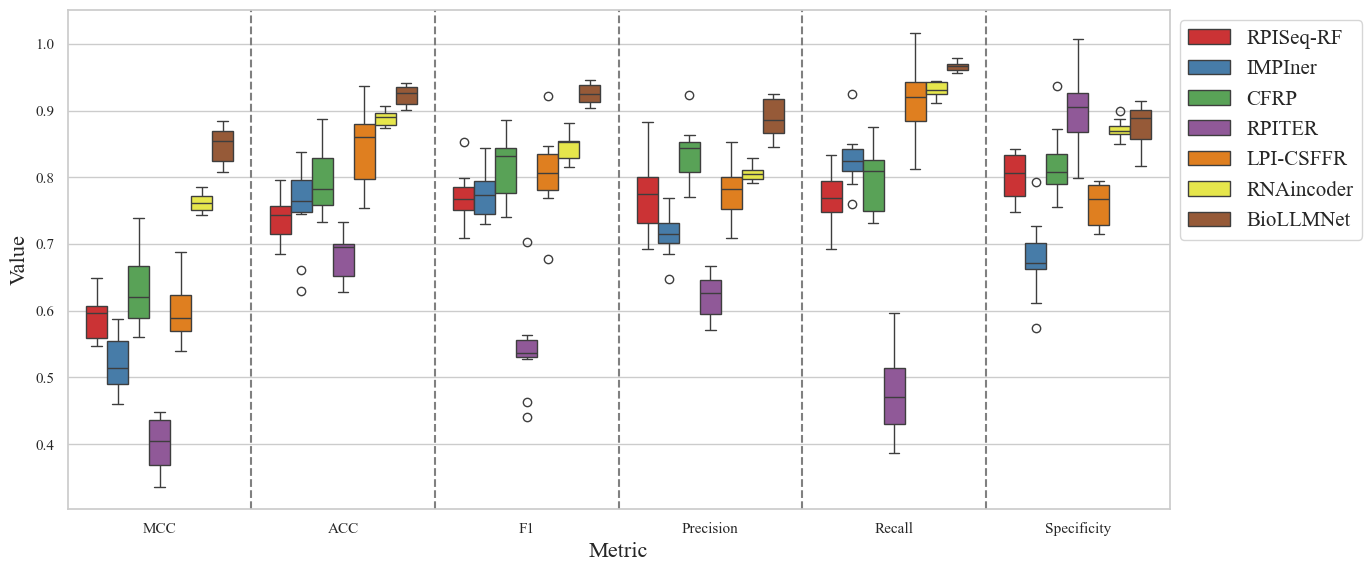

In [67]:

# Generate synthetic data for existing methods
np.random.seed(42)
data = []
for method, metrics in methods.items():
    for metric, (mean, std) in metrics.items():
        for fold in range(10):
            value = np.random.normal(mean, std)
            data.append([fold + 1, metric, value, method])

# Add BioLLMNet results to the data
for fold, metrics in biollmnet_results.items():
    for metric, value in metrics.items():
        # metric_name = metric.capitalize()  # Ensure consistent capitalization
        data.append([fold, metric, value, 'BioLLMNet'])

# Create DataFrame
df = pd.DataFrame(data, columns=['Fold', 'Metric', 'Value', 'Method'])

# Set the color palette
palette = sns.color_palette("Set1")

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x='Metric', y='Value', hue='Method', data=df, palette=palette)

# Add a title and labels
# plt.title('Cross-Validation Metrics by Method', fontsize=20, fontweight='bold')
plt.ylabel('Value', fontsize=16)
plt.xlabel('Metric', fontsize=16)

# Separate sections with lines
for i in range(1, len(df['Metric'].unique())):
    plt.axvline(x=i - 0.5, color='gray', linestyle='--')

# Adjust legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)



# Show the plot
plt.tight_layout()


# save image with 600 dpi
plt.savefig('RPI_1460.png', dpi=600)

plt.show()


In [94]:
# model.eval()
# gate_scores_list = []
# with torch.no_grad():
#     val_labels = []
#     val_preds = []
#     for embeddings, labels in train_dataloader:
#         # print(len(labels))
#         protein_emb, rna_emb = embeddings
#         protein_emb, rna_emb, labels = protein_emb.to(device), rna_emb.to(device), labels.to(device)
#         outputs, gate_scores = model(protein_emb, rna_emb)
#         # print(gate_scores.shape)
#         gate_scores_list.append(gate_scores.cpu().numpy())
#         outputs=outputs.squeeze()
#         val_labels.extend(labels.tolist())
#         val_preds.extend(outputs.cpu().numpy())

# val_mcc = calculate_mcc(val_labels, val_preds)
# print(f'Validation MCC: {val_mcc:.4f}')

Validation MCC: 0.9070


In [92]:
len(val_labels)

292

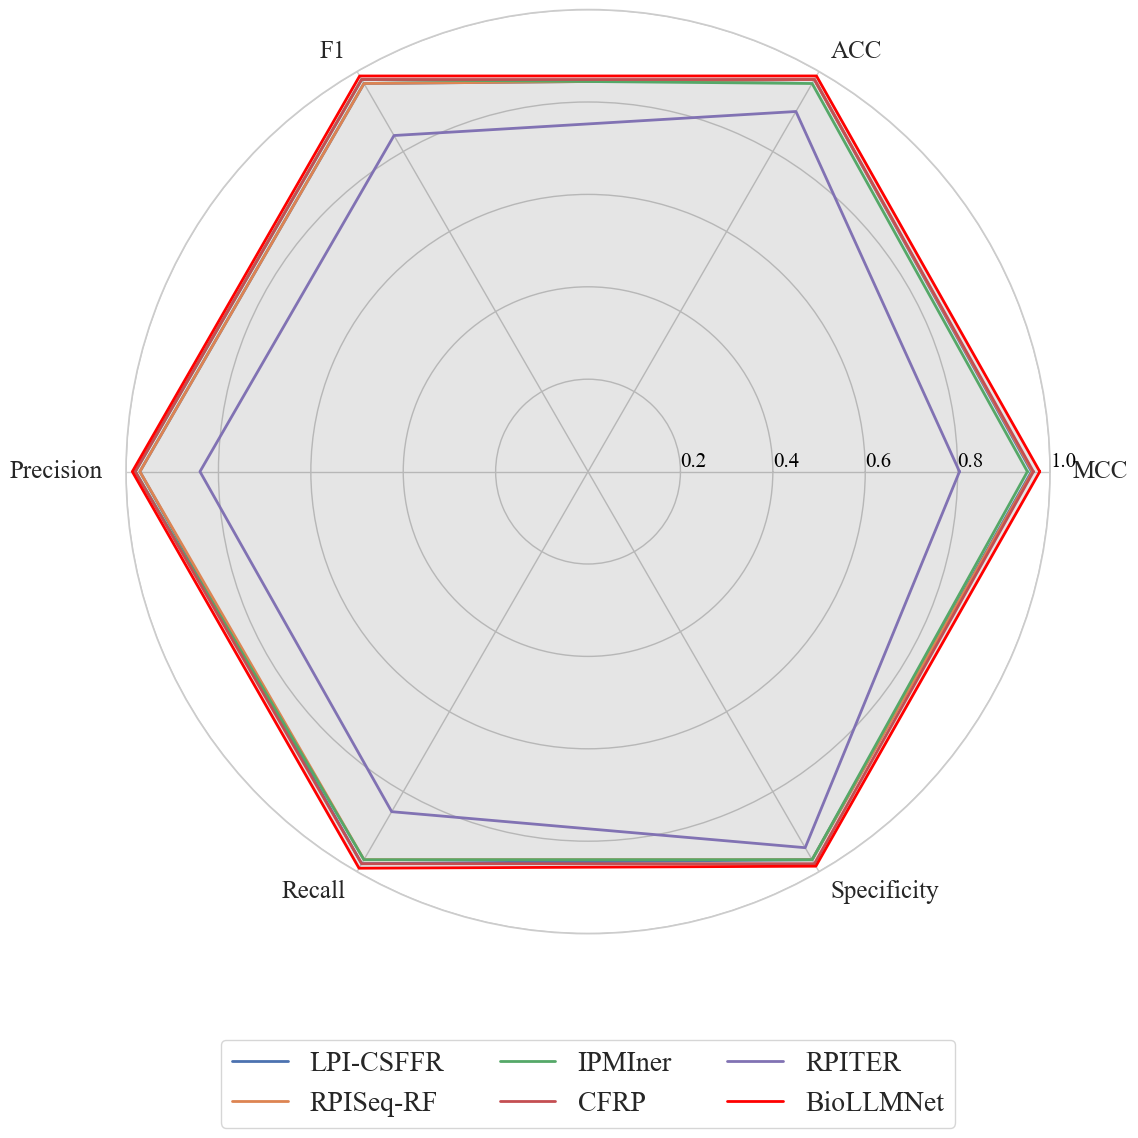

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# Define methods and their metrics
methods = {
    'LPI-CSFFR': {'MCC': 0.96, 'ACC': 0.98, 'F1': 0.97, 'Precision': 0.97, 'Recall': 0.98, 'Specificity': 0.97},
    'RPISeq-RF': {'MCC': 0.962, 'ACC': 0.98, 'F1': 0.97, 'Precision': 0.97, 'Recall': 0.97, 'Specificity': 0.97},
    'IPMIner': {'MCC': 0.951, 'ACC': 0.97, 'F1': 0.98, 'Precision': 0.98, 'Recall': 0.97, 'Specificity': 0.97},
    'CFRP': {'MCC': 0.964, 'ACC': 0.98, 'F1': 0.98, 'Precision': 0.98, 'Recall': 0.98, 'Specificity': 0.98},
    'RPITER': {'MCC': 0.804, 'ACC': 0.90, 'F1': 0.84, 'Precision': 0.84, 'Recall': 0.85, 'Specificity': 0.94},
    'BioLLMNet': {'MCC': 0.9777396918395473, 'ACC': 0.9888613770588022, 'F1': 0.9887834116886702, 'Precision': 0.9864111164147156, 'Recall': 0.9912854424780846, 'Specificity': 0.9862036763959052}
}

# Create a DataFrame
df = pd.DataFrame(methods).T

# Number of variables
categories = list(df.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(polar=True))

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Plot each individual method
for method in df.index:
    values = df.loc[method].tolist()
    values += values[:1]
    if method == 'BioLLMNet':
        ax.plot(angles, values, linewidth=2, linestyle='solid', color='red', label=method)
        ax.fill(angles, values, alpha=0.10, color='black')
    else:
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=method)
        ax.fill(angles, values, alpha=0.00)

# Add a title and labels
# plt.title('Radar Chart of Methods on RPI1807 Dataset', size=24, color='black', y=1.1)

# Draw one axe per variable + add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=18)

# Offset labels to make them clearer
for i, label in enumerate(ax.get_xticklabels()):
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    angle_rad = angles[i]
    if angle_rad < pi / 2:
        label.set_horizontalalignment('left')
    elif angle_rad < pi:
        label.set_horizontalalignment('right')
    elif angle_rad < 3 * pi / 2:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="black", size=15)
plt.ylim(0, 1)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=20)

# Save image with 600 dpi
plt.savefig('RPI1807_radar_chart.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


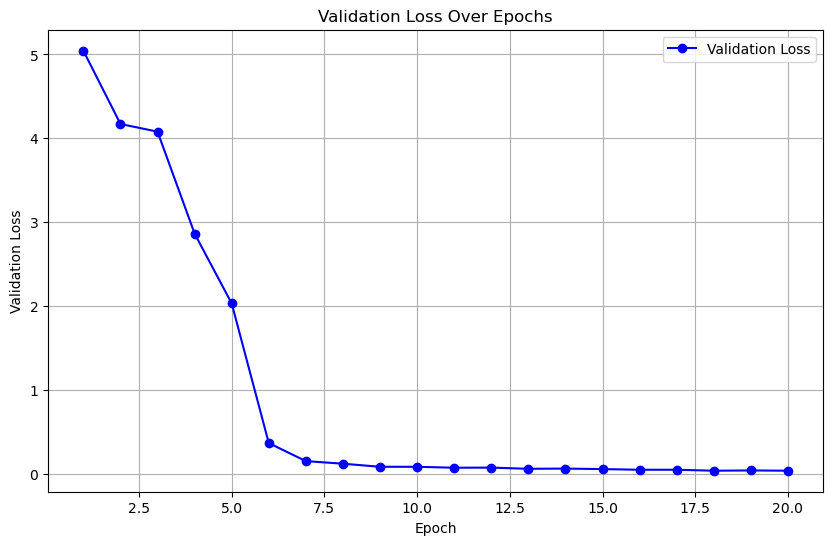

In [3]:
import matplotlib.pyplot as plt

# Validation loss values from your training log
val_loss = [
    5.04393, 4.17158, 4.07976, 2.86545, 2.03397, 
    0.37103, 0.15627, 0.12539, 0.08906, 0.08872, 
    0.07754, 0.07910, 0.06474, 0.06740, 0.06147, 
    0.05338, 0.05360, 0.04194, 0.04520, 0.04210
]

# Epoch numbers
epochs = list(range(1, len(val_loss) + 1))

# Plotting the validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()